In [1]:
!pip install scikit-uplift

     -------------------------------------- 42.1/42.1 kB 408.6 kB/s eta 0:00:00


In [2]:
!pip install catboost

     ---------------------------------------- 74.0/74.0 MB 4.4 MB/s eta 0:00:00
     ---------------------------------------- 47.0/47.0 kB 2.3 MB/s eta 0:00:00


Домашнее задание
1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from pprint import pprint

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from sklift.models import TwoModels
from sklift.models import ClassTransformation

from catboost import CatBoostClassifier

In [24]:
df = pd.read_csv('data.csv')
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [25]:
df = df.rename(columns={'conversion': 'target', 'offer': 'treatment'})
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [26]:
df['treatment'] = df['treatment'].apply(lambda i : 0 if i == 'No Offer' else 1)
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0


In [66]:
df.corr()

,recency,history,used_discount,used_bogo,is_referral,treatment,target
recency,1.000000,-0.246591,-0.031336,-0.026617,-0.052106,0.002828,-0.074765
history,-0.246591,1.000000,0.112677,0.114685,0.223279,0.003318,0.065153
used_discount,-0.031336,0.112677,1.000000,-0.816943,0.020900,-0.003115,0.006712
used_bogo,-0.026617,0.114685,-0.816943,1.000000,0.021346,0.002953,0.051999
is_referral,-0.052106,0.223279,0.020900,0.021346,1.000000,0.000394,-0.073924
treatment,0.002828,0.003318,-0.003115,0.002953,0.000394,1.000000,0.081073
target,-0.074765,0.065153,0.006712,0.051999,-0.073924,0.081073,1.000000


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   treatment      64000 non-null  int64  
 8   target         64000 non-null  int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 4.4+ MB


In [68]:
df_num_features = df.select_dtypes(include=['float64', 'int64'])
df_num_features.describe()

,recency,history,used_discount,used_bogo,is_referral,treatment,target
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.667094,0.146781
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.471257,0.353890
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,1.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,1.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000,1.000000


In [27]:
df['treatment'].value_counts()

1    42694
0    21306
Name: treatment, dtype: int64

In [28]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1),
                                                    df['target'],
                                                    test_size=0.33,
                                                    random_state=42)

In [29]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

In [30]:
treat_train = X_train['treatment']
treat_test = X_test['treatment']
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@30%': []
}

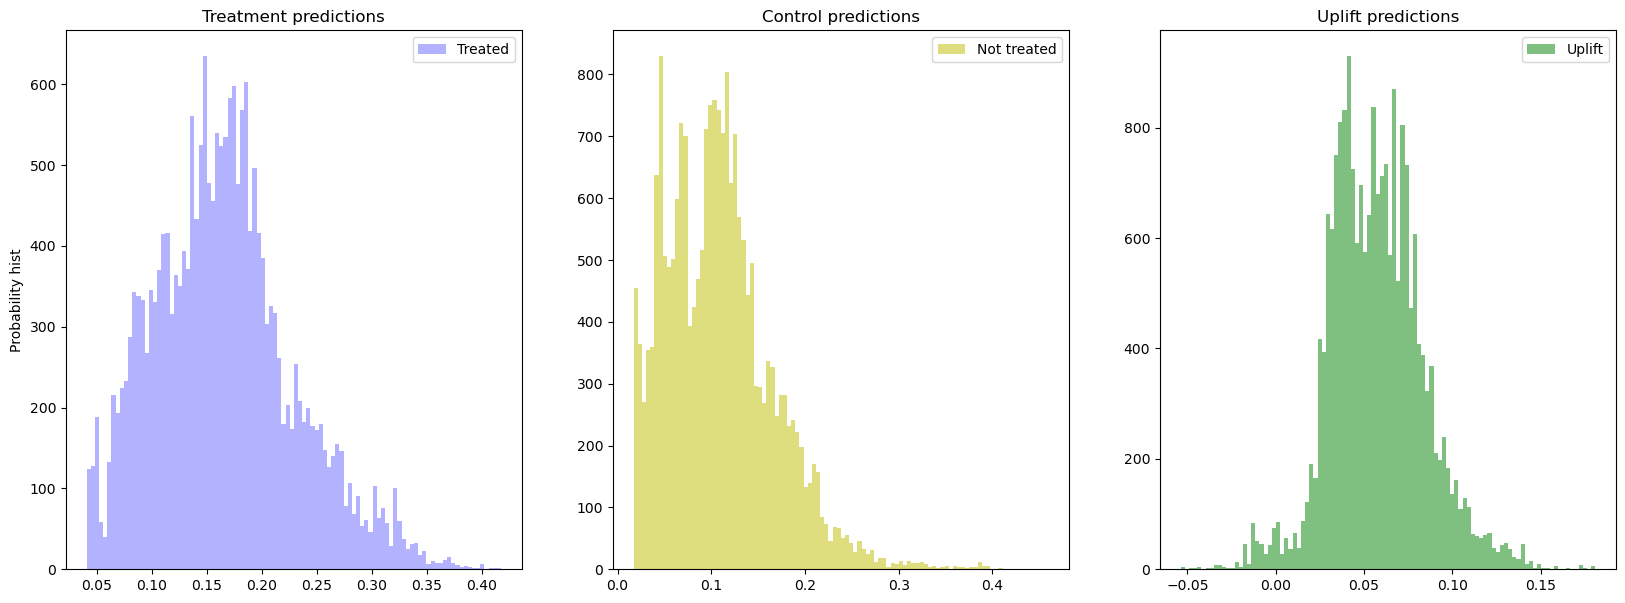

In [31]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.3)

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@30%'].append(sm_score_30)

sm_trmnt_preds = sm.trmnt_preds_
sm_ctrl_preds = sm.ctrl_preds_

plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [32]:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,is_referral,19.230532
1,treatment,15.733649
2,recency,12.950256
3,history,12.842657
4,used_bogo,12.393245
5,used_discount,7.896263
6,zip_code_Rural,7.563466
7,channel_Phone,5.956007
8,channel_Web,2.397393
9,channel_Multichannel,1.644685


In [33]:
from sklift.models import ClassTransformation

In [34]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@30%'].append(ct_score_30)

In [35]:
from sklift.models import TwoModels

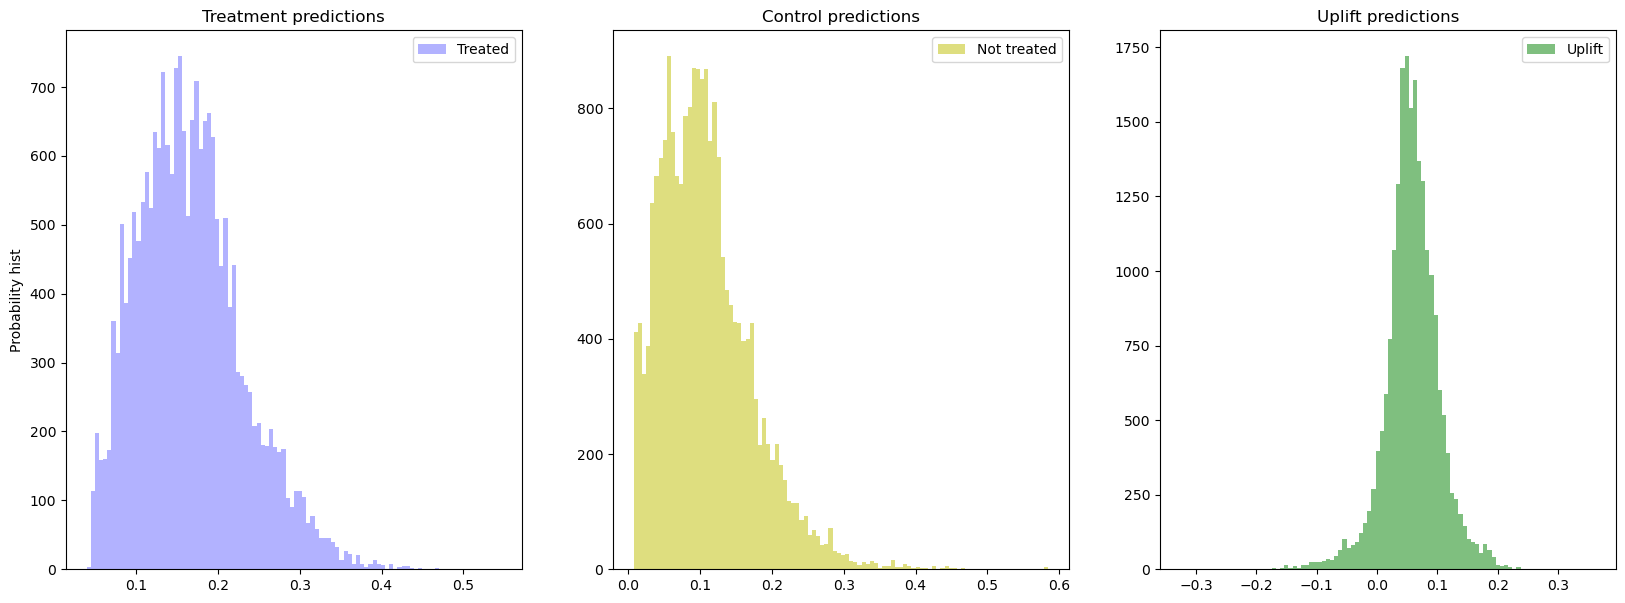

In [36]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla')

tm = tm.fit(
    X_train, y_train, treat_train)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@30%'].append(tm_score_30)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [37]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False).set_index('approach')

,uplift@10%,uplift@30%
approach,,
ClassTransformation,0.269593,0.183394
SoloModel,0.092437,0.085607
TwoModels,0.082563,0.082071


Построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

In [1]:
к сожалению, установить causalml не удалось

  Using cached causalml-0.13.0.tar.gz (535 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for causalml
Failed to build causalml
  Running setup.py install for causalml: started
  Running setup.py install for causalml: finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [67 lines of output]
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-cpython-39
  creating build\lib.win-amd64-cpython-39\causalml
  copying causalml\features.py -> build\lib.win-amd64-cpython-39\causalml
  copying causalml\match.py -> build\lib.win-amd64-cpython-39\causalml
  copying causalml\propensity.py -> build\lib.win-amd64-cpython-39\causalml
  copying causalml\__init__.py -> build\lib.win-amd64-cpython-39\causalml
  creating build\lib.win-amd64-cpython-39\causalml\dataset
  copying causalml\dataset\classification.py -> build\lib.win-amd64-cpython-39\causalml\dataset
  copying causalml\dataset\regression.py -> build\lib.win-amd64-cpython-39\causalml\dataset
  copying causalml\dataset\synthetic.py -> build\lib.win-amd64-cpython-39\causalml\dataset
  copying causalml\dataset\__init__.py -> build\lib.win-amd64-